---
## Logistic Regression
#### Author: Tianyi Mao
---

This project focuses on predicting students' math score using a dataset of students performance, following a 4-step process typical of a machine learning workflow:

**Step 1**: Data Cleaning and Analysis  
**Step 2**: Train the Model  
**Step 3**: Evaluate the Model  
**Step 4**: Performance Analysis

### Step 1: Data Inspection and Preprocessing  

In this step, the **StudentsPerformance** dataset is prepared for logistic regression. The target variable, **"test preparation course"**, is transformed into a binary format:  
- `1` = Completed  
- `0` = Not Completed  

**Steps**:  
- **Load and Inspect Data**:  
  - Display the first few rows.  
  - Check for missing values and data types.  
  - Confirm unique values in the target column.  

- **Transform Target Variable**:  
  - Convert "test preparation course" into a binary variable (`test_prep_binary`).  

- **Preprocess Features**:  
  - Apply **One-Hot Encoding** to categorical variables.  
  - Standardize numerical features (`math score`, `reading score`, `writing score`) using Z-score normalization.  

- **Split Data**:  
  - Divide the dataset into **training** (70%) and **testing** (30%) sets.  


In [30]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [18]:
data_path = '/Users/sherrymao/Documents/Git/INDE577-TianyiMao/Data/Performance_data/StudentsPerformance.csv'
data = pd.read_csv(data_path)

# Display the first 5 rows of the dataset
print("First 5 rows of the data:")
print(data.head())

# Check for missing values
print("\nMissing values in the dataset:")
print(data.isnull().sum())

# Inspect column names and data types
print("\nData Information:")
print(data.info())

# Display unique values in the 'test preparation course' column
print("\nUnique values in 'test preparation course':")
print(data['test preparation course'].unique())

# Binarize the target variable: 'test preparation course'
data['test_prep_binary'] = data['test preparation course'].apply(lambda x: 1 if x == 'completed' else 0)

# Drop the original 'test preparation course' column
data = data.drop(columns=['test preparation course'])

# Display the updated dataset
print("\nDataset after binarizing 'test preparation course':")
print(data.head())

# Encode categorical variables using One-Hot Encoding
data = pd.get_dummies(data, drop_first=True)

# Standardize numerical features
scaler = StandardScaler()
numerical_features = ['math score', 'reading score', 'writing score']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Define X (features) and y (target variable)
X = data.drop(columns=['test_prep_binary'])
y = data['test_prep_binary']

# Split the data into training and test sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print shapes of train and test sets
print("\nShapes of the datasets:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


First 5 rows of the data:
   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  

Missing values in the dataset:
gender                         0
race/ethnicity                 0
parental level of education    0
lu

### Step 2: Train the Logistic Regression Model  

In this step, we train the **Logistic Regression** model to predict whether a student has completed the test preparation course.

**Key Steps**:  
- **Split Data**: Use the training set to fit the model and reserve the test set for evaluation.  
- **Logistic Regression with Gradient Descent**:  
  - Use the sigmoid function to map input features to probabilities:  

$$
P(y=1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \dots + \beta_n x_n)}}
$$

  - Optimize the model using **cross-entropy loss** to measure the difference between predicted probabilities and actual values:  

$$
L = -\frac{1}{m} \sum_{i=1}^m \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

  - Update model weights iteratively using **gradient descent**.  

In [22]:
class gradient_descent_Logit_R():
    # Initialize
    def __init__(self) -> None:
        self.X = None
        self.variables = None
        self.y = None
        self.predictor = None
        self.n = None
        self.p = None
        self.bias = None
        self.gamma = None
        self.max_iter = None
        self.eta = None
        self.weights = None
        self.weights_history = []
        self.loss_history = [np.inf]
    
    # Sigmoid function
    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))

    # Cross-entropy loss for one data point
    def cross_entropy_loss(self, y, y_hat):
        return -y * np.log(y_hat) - (1.0 - y) * np.log(1.0 - y_hat)

    # Total cross-entropy loss
    def loss(self):
        total_loss = sum(self.cross_entropy_loss(self.y[i], self.sigmoid(x @ self.weights)) 
                         for i, x in enumerate(self.X))
        return total_loss

    # Gradient of loss
    def gradient_L(self):
        sigmoids = np.array([self.sigmoid(x @ self.weights) - self.y[i] for i, x in enumerate(self.X)])
        d_w = sigmoids @ self.X
        return d_w

    # Model fitting
    def fit(self, X, y, bias=True, gamma=0.01, max_iter=1000, eta=0.001):
        self.variables = X.columns
        self.predictor = y.name
        
        X = X.to_numpy()
        y = y.to_numpy()
        if bias:
            ones_column = np.ones((X.shape[0], 1))
            X = np.append(ones_column, X, axis=1)
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.p = X.shape[1]
        self.bias = bias
        self.gamma = gamma
        self.max_iter = max_iter
        self.eta = eta
        
        weights = np.random.rand(self.p)
        self.weights = weights
        self.weights_history.append(weights)
        for i in range(1, max_iter + 1):
            dw = self.gradient_L()
            weights = weights - gamma * dw
            self.weights = weights
            self.weights_history.append(weights)
            L = self.loss()
            self.loss_history.append(L)
            if i >= self.max_iter or abs(L - self.loss_history[i - 1]) <= self.eta:
                break
    
    # Predict new data
    def prediction(self, X, weights):
        X = X.to_numpy()
        if self.bias:
            ones_column = np.ones((X.shape[0], 1))
            X = np.append(ones_column, X, axis=1)
        labels = np.array([1, 0])
        y_hat = [self.sigmoid(x @ weights) for x in X]
        return [np.random.choice(labels, p=[y_hat_i, 1.0 - y_hat_i]) for y_hat_i in y_hat]


In [27]:
# Train the logistic regression model
model = gradient_descent_Logit_R()
model.fit(X_train, y_train, gamma=0.01, max_iter=1000)


### Step 3: Evaluate the Model  

In this step, we evaluate the performance of the **Logistic Regression** model on the test dataset. The evaluation includes metrics such as **accuracy**, a **confusion matrix**, and the **loss history** to assess the model's performance.

---

**Key Metrics for Evaluation**:  
- **Accuracy**: The proportion of correctly classified samples.  
- **Confusion Matrix**: A summary table showing true positive, true negative, false positive, and false negative predictions.  
- **Loss History**: Visualizes how the cross-entropy loss decreases during training, ensuring that the model has converged.

---

Logistic Regression Accuracy: 0.67
Precision: 0.54
Recall: 0.74
F1 Score: 0.62
Confusion Matrix:
[[121  69]
 [ 29  81]]


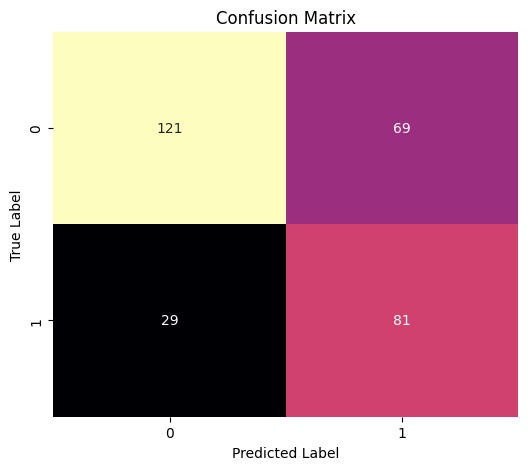

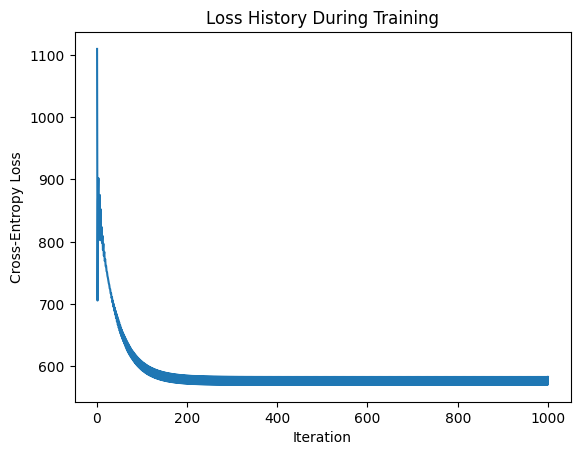

In [32]:
# Predict on the test set
y_pred = model.prediction(X_test, model.weights)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.2f}")

# Calculate Precision, Recall, and F1 Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, fmt='g', cmap="magma", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot loss history
plt.plot(model.loss_history)
plt.title("Loss History During Training")
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.show()



### Step 4: Performance Analysis

In this step, we analyze the performance of the **Logistic Regression** model on the test dataset.
The loss graph shows that the cross-entropy loss decreases sharply early on at around 200 iteration. It does shupport the convergence of the model. 
The accuracy score is 0.68, which indicates that there is some room for improvement. 
Precision score of 0.55 is relatively low, suggesting that there is a significant number of False Alarms. 
Recall score of 0.75 is relatively high, suggesting that the model is effective at identifying most positive cases. 